# Case Study 2
### Navigation
[EDA Tools](#edatools)
#### Tasks
1. [Clustering](#clustering)
1. [Association](#association)
1. [Text Analysis](#text)
1. [Web Log](#web)

# EDA Tools

<a name="edatools"></a>

In [1]:
def empty_string_values_in_columns(df):
    naughty_columns = []
    
    for col in range(len(df.columns)):
        # store name of current col
        current_col = df.columns[col]

        # series checking content is NOT a blank string
        bools = df[current_col] != ''

        # record column with ANY False value, i.e. contains a blank string
        if not bools.all():
            naughty_columns.append(current_col)
    
    if len(naughty_columns) > 0:
        print("Columns to investigate:")
        print(naughty_columns)
    else:
        print("No empty strings found in any columns.")
    return naughty_columns

# check for NAs
def num_NAs_per_col(df):
    info = df.isna().sum()

    for i in range(len(df.columns)):
        print(f"{info.index[i]}, {info[i]}")


# programmatically find num_cluster with max silhouette score 
def get_key_by_value(dictionary, search_value):
    for key, value in dictionary.items():
        if value == search_value:
            return key
    return None  # Return None if the value is not found in the dictionary

In [2]:
import warnings
warnings.filterwarnings("ignore")

# random state
rs = 21

***
# Task 1: Clustering Analysis <a name="clustering"></a>

### Task 1 Navigation
1. [Data Prep Pipeline](#clustering-data-preprocess)
1. [Variables in Analysis](#1.2)
1. [Default Cluster Model](#1.3)
1. [Feature Standardaisation](#1.4)
1. [Interpretation of Best Model](#1.5)
1. [Euclidean Distances](#1.6)
1. [Applications / Use Cases](#1.7)

In [3]:
# import libraries and load data
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial import distance

# load dataset
music_data = pd.read_csv('Music_shop_v1.csv', na_filter=False, encoding='latin-1')

## 1.1
### Data Cleaning

Describe your data cleaning approach and clean the dataset.

<a name="clustering-data-preprocess"></a>

In [4]:
def preprocess_music_data(raw_music_data):
    # drop duplicate rows 
    preprocess_df = raw_music_data.drop_duplicates()
    
    # replace blank strings with NaN, typecast to float
    preprocess_df['Energy'] = preprocess_df['Energy'].replace('', np.nan).astype(float)
    preprocess_df['Loudness'] = preprocess_df['Loudness'].replace('', np.nan).astype(float)
    preprocess_df['Instrumentalness'] = preprocess_df['Instrumentalness'].replace('', np.nan).astype(float)

    # drop NaNs
    preprocess_df.dropna(inplace=True)
    
    # drop outliers / beyond permissible range
    # map invalid values
    preprocess_df.loc[preprocess_df['Energy'] > 1, 'drop_col'] = True
    preprocess_df.loc[preprocess_df['Instrumentalness'] > 1, 'drop_col'] = True
    preprocess_df.loc[preprocess_df['Speechiness'] > 1, 'drop_col'] = True
    # drop from df
    preprocess_df = preprocess_df[preprocess_df.drop_col != True]
    
    # drop unnecessary features
    preprocess_df = preprocess_df.drop(columns = ['ID', 'Type', 'Name', 'drop_col', 'time_signature'])
    
    # reset index
    preprocess_df.reset_index(drop=True, inplace=True)
    
    return preprocess_df

In [5]:
# preprocess data 
music_df = preprocess_music_data(music_data)

[Return to Task Navigation](#Task-1-Navigation)
***

## 1.2
### Variables included in analysis: roles and measurement level set? Justify your choice.

In [7]:
music_df.columns

Index(['Energy', 'Loudness', 'Speechiness', 'Instrumentalness'], dtype='object')

[Return to Task Navigation](#Task-1-Navigation)
***

## 1.3
### Default Clustering Model with `k = 3`

In [8]:
# convert df values to matrix
X = music_df.values
default_cluster = KMeans(n_clusters=3, random_state=rs).fit(X)

### 1.3.a
#### How many data points (audio tracks) are assigned into each cluster?

In [9]:
# assign cluster ID to each record in X
default_y = default_cluster.predict(X)
music_df['Default_Cluster_ID'] = default_y

# how many records are in each cluster
print("Default Model Cluster Membership")
print(music_df['Default_Cluster_ID'].value_counts())

Default Model Cluster Membership
1    1612
0     766
2     304
Name: Default_Cluster_ID, dtype: int64


[Return to Task Navigation](#Task-1-Navigation)
***

### 1.3.b
#### Plot default cluster distribution & Explain key characteristics.

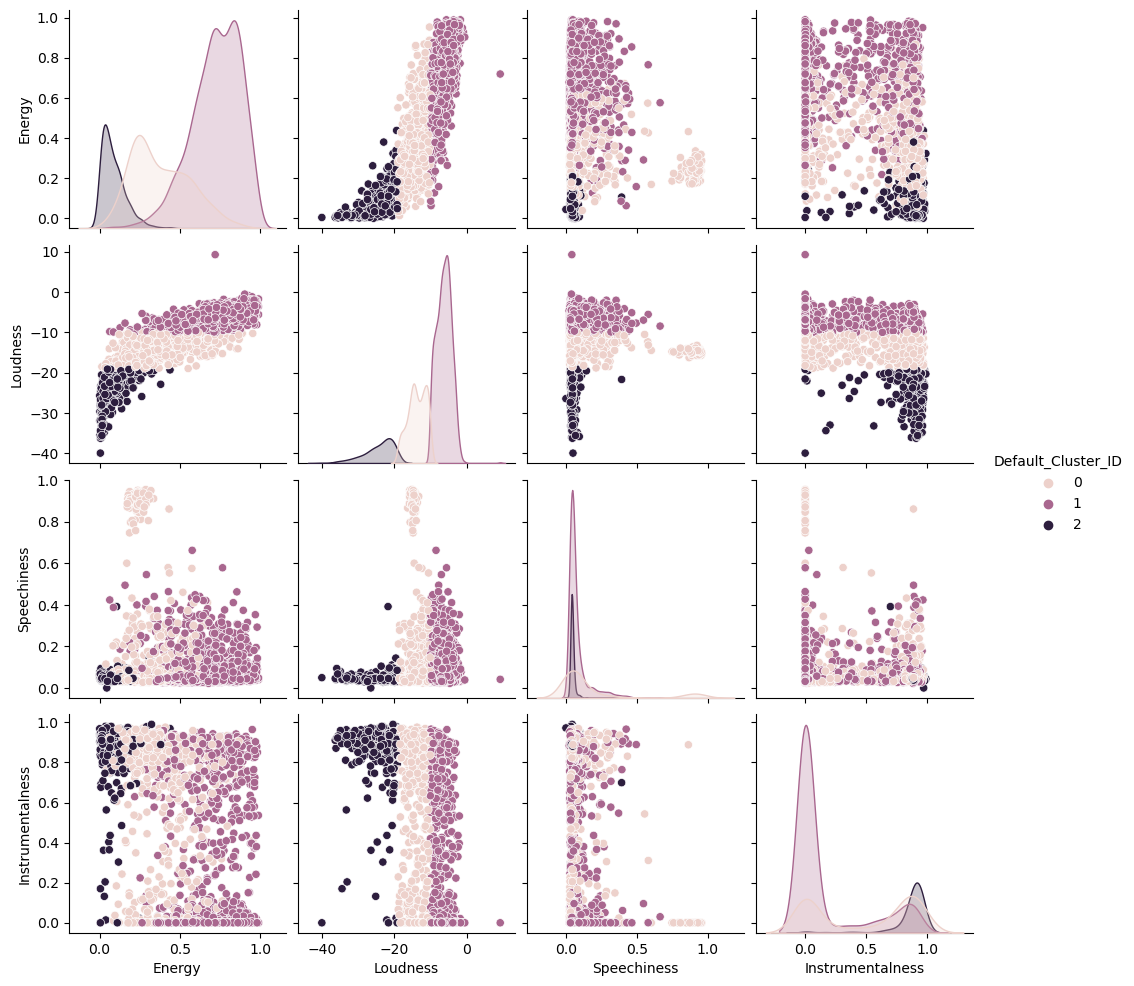

In [10]:
# pairplot the cluster distribution
cluster_default = sns.pairplot(music_df, hue='Default_Cluster_ID')
plt.show()
# drop unnecessary col to avoid interferring with future analyses
music_df.drop(columns='Default_Cluster_ID', inplace=True)

*Explanation of key characteristics of each cluster.*

[Return to Task Navigation](#Task-1-Navigation)
***

## 1.4
#### Effect of standardization on the default clustering model

In [11]:
# scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

scaled_cluster = KMeans(n_clusters=3, random_state=rs).fit(X_scaled)

# assign cluster ID to each record in X_scaled
y_scaled = scaled_cluster.predict(X_scaled)
music_df['Scaled_Cluster_ID'] = y_scaled

In [12]:
# how many records are in each cluster
print("Scaled Cluster Membership")
print(music_df['Scaled_Cluster_ID'].value_counts())

Scaled Cluster Membership
1    1780
0     795
2     107
Name: Scaled_Cluster_ID, dtype: int64


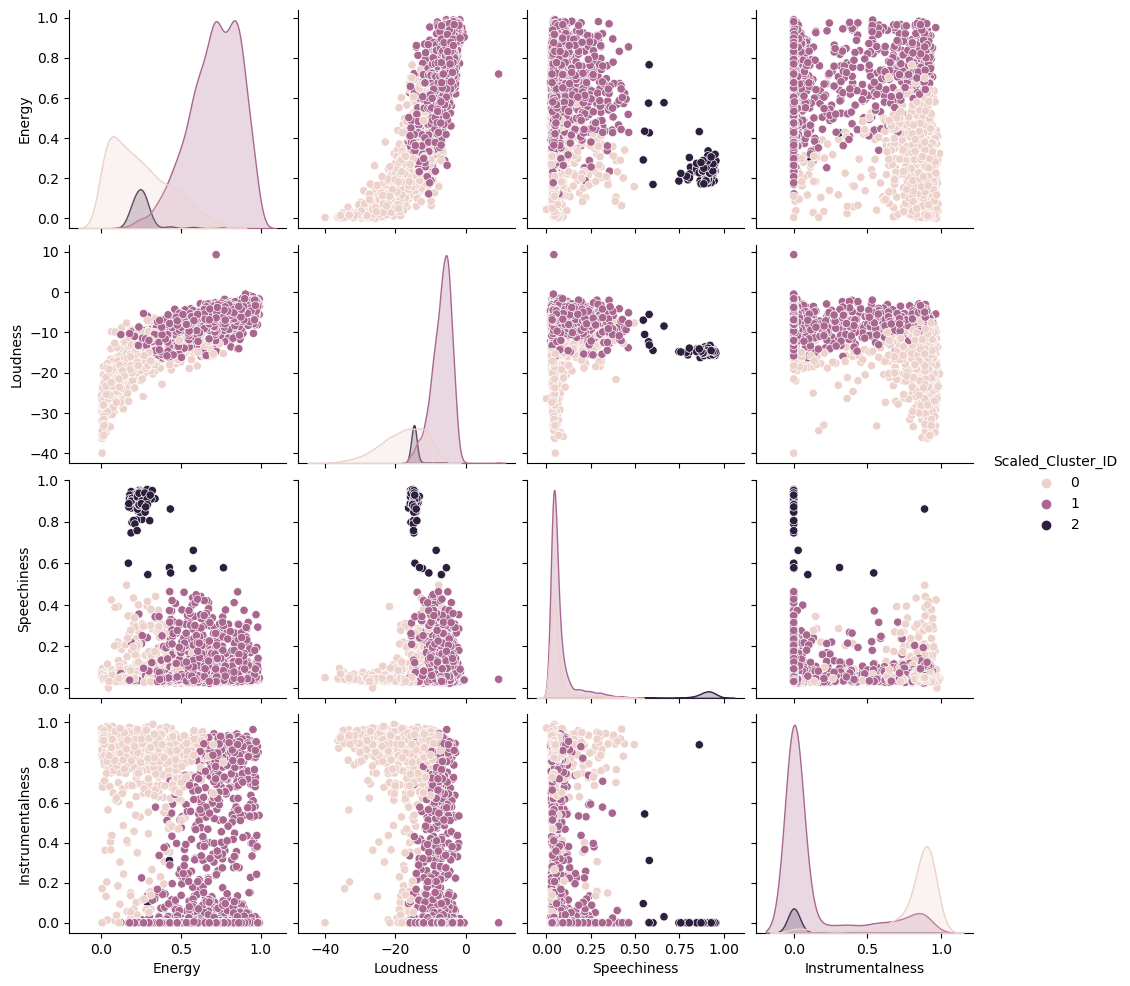

In [13]:
# pairplot scaled cluster distribution
cluster_scaled = sns.pairplot(music_df, hue='Scaled_Cluster_ID')
plt.show()

#### Does the variable normalization process enable a better model?

In [14]:
# silhouette scores and clustering error for each model
# note the significant drop in 
print("Default model - silhouette score: ", silhouette_score(X, default_cluster.predict(X)))
print("Default model - clustering error: ", default_cluster.inertia_)
print()
print("Scaled model - silhouette score: ", silhouette_score(X_scaled, scaled_cluster.predict(X_scaled)))
print("Scaled model - clustering error: ", scaled_cluster.inertia_)

Default model - silhouette score:  0.6019566245808277
Default model - clustering error:  16548.328213822275

Scaled model - silhouette score:  0.5372775520565879
Scaled model - clustering error:  3580.254117380004


[Return to Task Navigation](#Task-1-Navigation)
***

## 1.5
### Interpretation of Cluster Analysis Results

Using the best model by characterizing the nature of each cluster.

Distribution for cluster 0


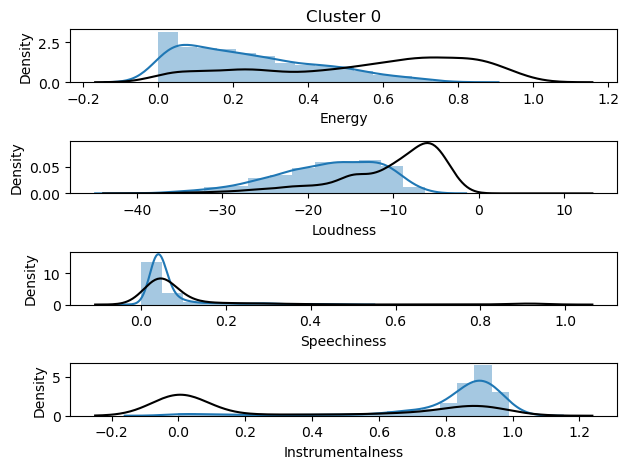

Distribution for cluster 1


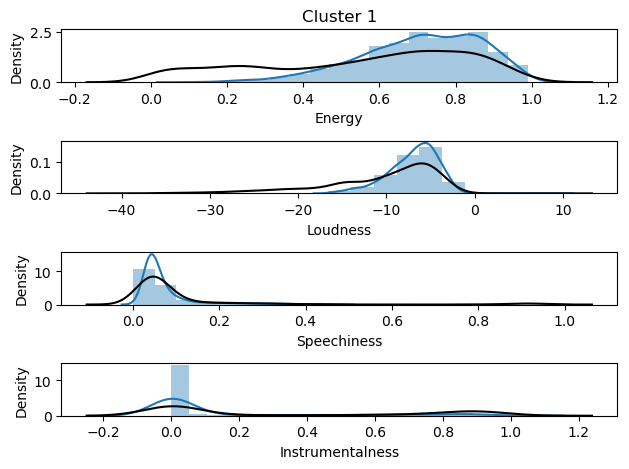

Distribution for cluster 2


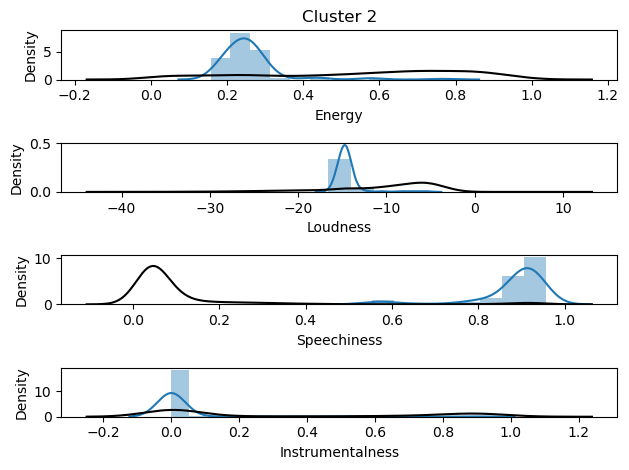

In [15]:
# prepare the column and bin size
cols = ['Energy', 'Loudness', 'Speechiness', 'Instrumentalness']
n_bins = 20

for cluster in range(3):
    # inspecting cluster [x]
    print("Distribution for cluster {}".format(cluster))

    # create subplots
    fig, ax = plt.subplots(nrows=len(cols))
    ax[0].set_title("Cluster {}".format(cluster))

    for j, col in enumerate(cols):
        # create the bins
        bins = np.linspace(min(music_df[col]), max(music_df[col]), 20)
        # plot distribution of the cluster using histogram
        sns.distplot(music_df[music_df['Scaled_Cluster_ID'] == cluster][col], bins=bins, ax=ax[j], norm_hist=True)
        # plot the normal distribution with a black line
        sns.distplot(music_df[col], bins=bins, ax=ax[j], hist=False, color="k")

    plt.tight_layout()
    plt.show()


[Return to Task Navigation](#Task-1-Navigation)
***

## 1.6

#### Finding Optimal $K$

In [74]:
# list to save the clusters and inertia 
clusters = []
inertia_vals = []

explore_range = range(2, 7, 1)

for k in explore_range:
    # train clustering with the specified K
    model = KMeans(n_clusters=k, random_state=rs)
    model.fit(X_scaled)
    
    # append model to cluster list
    clusters.append(model)
    inertia_vals.append(model.inertia_)

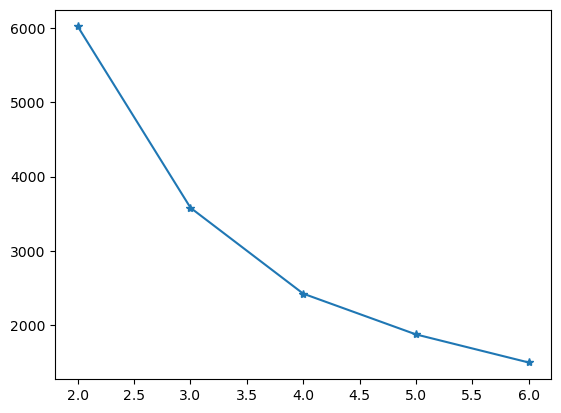

In [75]:
# plot the inertia vs K values
plt.plot(explore_range, inertia_vals, marker='*')
plt.show()

In [76]:
# programmatically generate and store silhouette scores for later
cluster_silhouettes = {}

for clust in range(len(clusters)):
    key = clusters[clust].n_clusters
    value = silhouette_score(X_scaled, clusters[clust].predict(X_scaled))
    cluster_silhouettes[key] = value
    
    print(clusters[clust])
    print(f"Silhouette score for k={key}", value)
    print()

KMeans(n_clusters=2, random_state=21)
Silhouette score for k=2 0.4863459825125124

KMeans(n_clusters=3, random_state=21)
Silhouette score for k=3 0.5372775520565879

KMeans(n_clusters=4, random_state=21)
Silhouette score for k=4 0.49582500885454744

KMeans(n_clusters=5, random_state=21)
Silhouette score for k=5 0.4414691102621376

KMeans(n_clusters=6, random_state=21)
Silhouette score for k=6 0.4328685261201394



In [77]:
max_sil_score = max(cluster_silhouettes.values())
max_sil_clusters = get_key_by_value(cluster_silhouettes, max_sil_score)

In [78]:
print("Number of clusters: ", max_sil_clusters, "\nSilhouette Score: ", max_sil_score)

Number of clusters:  3 
Silhouette Score:  0.5372775520565879


In [79]:
# generate model to calculate cluster distances
opti_scaled_cluster = KMeans(n_clusters=max_sil_clusters, random_state=rs).fit(X_scaled)

#### Euclidean Distances between cluster centers based on the optimal $K$

In [80]:
# Initialize a dictionary to store distances
distances = {}

# Iterate through each point
for i, point1 in enumerate(opti_scaled_cluster.cluster_centers_):
    for j, point2 in enumerate(opti_scaled_cluster.cluster_centers_):
        if i != j:  # Ensure you don't calculate the distance from a point to itself
            this_distance = distance.euclidean(point1, point2)
            distances[(i, j)] = this_distance

min_dist = min(distances.values())
max_dist = max(distances.values())
avg_dist = sum(distances.values()) / len(distances)

print(f'minimum distance between cluster centres of {min_dist:.3} units.')
print(f'maximum distance between cluster centres of {max_dist:.3} units.')
print(f'average distance between cluster centres of {avg_dist:.3} units.')

minimum distance between cluster centres of 2.92 units.
maximum distance between cluster centres of 5.11 units.
average distance between cluster centres of 4.36 units.


#### Explain your method for finding the optimal $K$.

Initially, we used the **elbow method** to find a local minima in the $K$ values vs. *clustering error* plot, as the change to a shallower gradient indicated that each additional cluster beyond that point did not meaningfully reduce the clustering error, i.e., improve the internal cohesion of clusters. We identified an elbow around $K=3$ and evaluated the silhouette scores for $K=3$ to $K=6$ to determine the optimal number of clusters.

In [82]:
# code block
print(f'We found that K={max_sil_clusters} was optimal, with a silhouette score of {max_sil_score:.3}.')

We found that K=3 was optimal, with a silhouette score of 0.537.


[Return to Task Navigation](#Task-1-Navigation)
***

### Navigation
[EDA Tools](#edatools)
#### Tasks
1. [Clustering](#clustering)
1. [Association](#association)
1. [Text Analysis](#text)
1. [Web Log](#web)

***
# Task 2: Association Analysis<a name="association"></a>

### Task 2 Navigation
1. [Data Prep Pipeline](#association-data-preprocess)
    1. [Data Prep Notes](#2.1)
1. [Variables in Analysis](#2.2)
1. [Association Model](#2.3)
1. [Plots of Evaluation Measures](#2.4)
1. [Tea Rules](#2.5)
1. [Shampoo Ruels](#2.6)

1. [Applications / Use Cases](#2.7)

In [24]:
# load packages
from apyori import apriori
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.cm import ScalarMappable

# load dataset
pos_data = pd.read_csv('POS_TRANS_v1.csv', na_filter=False, low_memory=False)

In [25]:
# functions for task 2
def convert_apriori_results_to_pandas_df(results):
    rules = []

    for rule_set in results:
        for rule in rule_set.ordered_statistics:
            # items_base = left side of rules, items_add = right side
            # support, confidence and lift for respective rules
            rules.append([','.join(rule.items_base),
                          ','.join(rule.items_add),
                          rule_set.support,
                          rule.confidence, rule.lift])
    
    # typecast it to pandas df
    return pd.DataFrame(rules, columns=['Left_side', 'Right_side',
                                        'Support','Confidence', 'Lift'])

## 2.1
### Data Cleaning

Describe your data cleaning approach and clean the dataset.

<a name="association-data-preprocess"></a>

In [26]:
def preprocess_pos_data(raw_pos_data):
    # drop duplicates
    preprocess_df = raw_pos_data.drop_duplicates()
    
    # replace blank strings with nan
    preprocess_df['Transaction_Id'] = preprocess_df['Transaction_Id'].replace('', np.nan)
    preprocess_df['Quantity'] = preprocess_df['Quantity'].replace('', np.nan)

    # drop rows containing nan's
    preprocess_df.dropna(inplace = True)
    
    # drop unnecessary features
    preprocess_df.drop(columns = ['Location', 'Transaction_Date', 'Quantity'], inplace = True)
    
    # typecast as needed
    preprocess_df['Product_Name'] = preprocess_df['Product_Name'].astype(str)
    preprocess_df['Transaction_Id'] = preprocess_df['Transaction_Id'].astype(int)
    
    # reset index
    preprocess_df.reset_index(drop=True, inplace=True)
    
    return preprocess_df

In [27]:
pos_df = preprocess_pos_data(pos_data)

[Return to Task Navigation](#Task-2-Navigation)

## 2.2
### Variables included in analysis

Variable roles and measurement level set? Justify choices.

In [28]:
pos_df.columns

Index(['Transaction_Id', 'Product_Name'], dtype='object')

[Return to Task Navigation](#Task-2-Navigation)
***

## 2.3
### Association Mining

In [29]:
# run apriori and use the defined function to generate a df of the results

transactions = pos_df.groupby(['Transaction_Id'])['Product_Name'].apply(list)

# type cast the transactions from pandas into normal list format
transaction_list = list(transactions)

# run apriori
results = list(apriori(transaction_list, min_support=0.01,
                      min_confidence=0.3))

result_df = convert_apriori_results_to_pandas_df(results)

### 2.3.a
#### Rule with highest *lift* value

In [31]:
# sort all acquired rules descending by lift
desc_lift = result_df.sort_values(by='Lift', ascending=False)
print(desc_lift.head(10))

          Left_side   Right_side   Support  Confidence      Lift
0            Butter  Conditioner  0.021815    0.323929  3.600976
16      Yoghurt,Tea          Egg  0.016665    0.411126  2.798938
4   Cordial,Shampoo      Yoghurt  0.011390    0.463762  2.711953
14          Egg,Tea      Yoghurt  0.016665    0.458649  2.682051
10      Shampoo,Tea          Egg  0.011945    0.377230  2.568177
17      Shampoo,Tea      Yoghurt  0.013720    0.433286  2.533737
11      Egg,Shampoo      Yoghurt  0.013175    0.410692  2.401613
2       Cordial,Tea          Egg  0.010955    0.346348  2.357933
13  Yoghurt,Shampoo          Egg  0.013175    0.331197  2.254779
3           Egg,Tea      Cordial  0.010955    0.301500  2.234552


### 2.3.b
#### Rule with highest *confidence* value

In [32]:
# sort all acquired rules descending by confidence
desc_conf = result_df.sort_values(by='Confidence', ascending=False)
print(desc_conf.head(10))

          Left_side Right_side   Support  Confidence      Lift
4   Cordial,Shampoo    Yoghurt  0.011390    0.463762  2.711953
14          Egg,Tea    Yoghurt  0.016665    0.458649  2.682051
17      Shampoo,Tea    Yoghurt  0.013720    0.433286  2.533737
16      Yoghurt,Tea        Egg  0.016665    0.411126  2.798938
11      Egg,Shampoo    Yoghurt  0.013175    0.410692  2.401613
15      Yoghurt,Egg        Tea  0.016665    0.381699  1.581798
6       Cordial,Tea    Yoghurt  0.012005    0.379545  2.219473
10      Shampoo,Tea        Egg  0.011945    0.377230  2.568177
1       Egg,Cordial        Tea  0.010955    0.374658  1.552617
8       Egg,Shampoo        Tea  0.011945    0.372350  1.543054


[Return to Task Navigation](#Task-2-Navigation)
***

## 2.4
### *Confidence, lift*, and *support* plot of Association Mining rules.

Interpret them to discuss the rule set obtained.

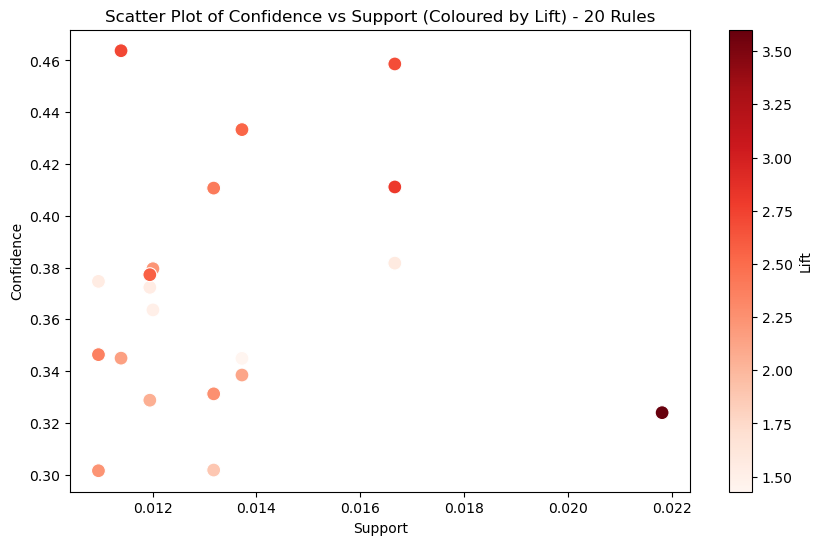

In [85]:
# Scatter plot with continuous color map
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(x='Support', y='Confidence', hue='Lift', data=result_df, palette='Reds', s=100, legend=False)
num_rules = len(result_df)
plt.title(f'Scatter Plot of Confidence vs Support (Coloured by Lift) - {num_rules} Rules')
plt.xlabel('Support')
plt.ylabel('Confidence')
sm = ScalarMappable(cmap='Reds', norm=plt.Normalize(result_df['Lift'].min(), result_df['Lift'].max()))
sm.set_array([])
colorbar = plt.colorbar(sm)
colorbar.set_label('Lift')
plt.show()

[Return to Task Navigation](#Task-2-Navigation)
***

## 2.5
### *Tea* Associations

In [34]:
# Filter the association rules to include only rules with 'Tea' on the left side
tea_rules = result_df[result_df.Left_side.str.contains('Tea')]

### 2.5.a
#### Number of rules in *Tea* subset.

In [35]:
# Count the number of rules in the subset
num_tea_rules = len(tea_rules)
print(f"There are {num_tea_rules} rules with 'Tea' on the left side.")

There are 9 rules with 'Tea' on the left side.


### 2.5.b
#### Interpretation: what are the other products these individuals are most likely to purchase?

In [36]:
# slice for rules with high confidence
conf_threshold = 0.3

top_tea_rules = tea_rules[tea_rules.Confidence > conf_threshold]

# filter for rules with positive correlation
top_tea_rules = top_tea_rules[top_tea_rules.Lift > 1]

# Sort the rules within the subset by confidence in descending order
top_tea_rules.sort_values(by='Confidence', ascending=False, inplace=True)

# reset index to enable FOR loop
top_tea_rules.reset_index(drop=True, inplace=True)

In [37]:
# initialise empty list for products
tea_top_products = []

# record each UNIQUE individual item
for RHS_prods in range(len(top_tea_rules.Right_side)):
    # if the RHS contains only multiple items
    if ',' in top_tea_rules.Right_side[RHS_prods]:
        # split into array of each item
        current_prods = top_tea_rules.Right_side[RHS_prods].split(',')
        # cycle through products and add to list if not already present
        for prod in current_prods:
            if prod not in tea_top_products:
                tea_top_products.append(prod)
    # only one RHS product in rule; add to list if not already present
    elif top_tea_rules.Right_side[RHS_prods] not in tea_top_products:
        tea_top_products.append(top_tea_rules.Right_side[RHS_prods])

In [38]:
# Print the top products
print(f"More than {conf_threshold:.0%} of customers who purchased Tea also purchased:")
for product in tea_top_products:
    print(f"- {product}")

More than 30% of customers who purchased Tea also purchased:
- Yoghurt
- Egg
- Shampoo
- Cordial


[Return to Task Navigation](#Task-2-Navigation)
***

## 2.6
### Interpretation: Products to boost *Shampoo* sales.

In [39]:
# Filter the association rules to include only rules with 'Shampoo' on RHS
shampoo_rules = result_df[result_df.Right_side.str.contains('Shampoo')]

# filter for rules with positive correlation
shampoo_rules = shampoo_rules[shampoo_rules.Lift > 1]

# Sort the rules within the subset by lift in descending order
shampoo_rules.sort_values(by='Lift', ascending=False, inplace=True)

# reset index to enable FOR loop
shampoo_rules.reset_index(drop=True, inplace=True)

In [40]:
# initialise empty list for products
shampoo_boosters = []

# record each UNIQUE individual item
for LHS_prods in range(len(shampoo_rules.Left_side)):
    # if the LHS contains multiple items
    if ',' in shampoo_rules.Left_side[LHS_prods]:
        # split into array of each item
        current_prods = shampoo_rules.Left_side[LHS_prods].split(',')
        # cycle through products and add to list if not already present
        for prod in current_prods:
            if prod not in shampoo_boosters:
                shampoo_boosters.append(prod)
    # only one LHS product in rule; add to list if not already present
    elif shampoo_rules.Left_side[LHS_prods] not in shampoo_boosters:
        shampoo_boosters.append(shampoo_rules.Left_side[LHS_prods])

In [93]:
# Print the top products
print(f"The identified rules indicate that Shampoo was, on average, {shampoo_rules.Lift.mean():.2} times more likely to be purchased if any combination of these products were also being purchased:")
for product in shampoo_boosters:
    print(f"- {product}")

The identified rules indicate that Shampoo was, on average, 2.0 times more likely to be purchased if any combination of these products were also being purchased:
- Yoghurt
- Cordial
- Tea
- Egg


[Return to Task Navigation](#Task-2-Navigation)
***

### Navigation
[EDA Tools](#edatools)
#### Tasks
1. [Clustering](#clustering)
1. [Association](#association)
1. [Text Analysis](#text)
1. [Web Log](#web)

***
# Task 3: Text Analysis<a name="text"></a>

### Task 3 Navigation
1. [Variables in Analysis](#3.1)
    1. [Data Preprocessing](#text-data-preprocess)
1. [10 Least Useful Terms](#3.2)
1. [Disregarded Terms](#3.3)
1. [Weighting Option and Input Features](#3.4)
1. [Optimal $K$](#3.5)
1. [Output Cluster Interpretations](#3.6)
1. [Applications / Use Cases](#3.7)

In [42]:
# import packages
import string
import pandas as pd

# natural language toolkit
from nltk.corpus import stopwords as sw
from nltk.corpus import wordnet as wn
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag

# scikit-learn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

# maths
from scipy.spatial.distance import euclidean
from math import sqrt

# load dataset
# M_metadata_v1.csv
movie_data = pd.read_csv('M_metadata_v1.csv', na_filter=False)

## 3.1
### Variables included in analysis

What were the variables roles and measurement levels set to? Justify choices.

- Task 3 description: *perform text analysis... to determine clusters of movies based on... the movie descriptions*
- Only "Description" used as this is the constraint given in the assignemnt instructions

#### Initialise Resources & Constants

In [43]:
lemmatizer = WordNetLemmatizer()
punct = set(string.punctuation)
# stopwords are not initialised here as...
# different sets are used throughout the analysis.

#### Initialise Functions

In [44]:
# function to visualise text cluster
def visualise_text_cluster(n_clusters, cluster_centers, terms, num_word = 10):
    # -- Params --
    # cluster_centers: cluster centers of fitted/trained KMeans/other centroid-based clustering
    # terms: terms used for clustering
    # num_word: number of terms to show per cluster. Change as you please.
    
    # find features/terms closest to centroids
    ordered_centroids = cluster_centers.argsort()[:, ::-1]
    
    for cluster in range(n_clusters):
        print("Top terms for cluster {}:".format(cluster), end=" ")
        for term_idx in ordered_centroids[cluster, :num_word]:
            print(terms[term_idx], end=', ')
        print('\n')

# creates tf-idf terms; a bit slow, run only occasionaly
# Param - document_col: collection of raw document text that you want to analyse
# Param - optimise: determines which tokenizer to use, with/without stopwords
def calculate_tf_idf_terms(document_col, optimise=False):
    
    if optimise: # strip stopwords 
        # use count vectorizer to find TF and DF of each term
        count_vec = CountVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2))
    else: # default (not stopwords) vector
        # use count vectorizer to find TF and DF of each term
        count_vec = CountVectorizer(tokenizer=cab_tokenizer_no_stop, ngram_range=(1,2))
    
    X_count = count_vec.fit_transform(document_col)
    
    # create list of terms and their tf and df
    terms = [{'term': t, 'idx': count_vec.vocabulary_[t],
              'tf': X_count[:, count_vec.vocabulary_[t]].sum(),
              'df': X_count[:, count_vec.vocabulary_[t]].count_nonzero()}
             for t in count_vec.vocabulary_]
    
    return terms

# visualisation of ZIPF law
# --- Param ---
    # terms: collection of terms dictionary from calculate_tf_idf_terms function
    # itr_step: used to control how many terms that you want to plot.
    #           Num of terms to plot = N terms / itr_step
def visualise_zipf(terms, itr_step = 50):
    # sort terms by its frequency
    terms.sort(key=lambda x: (x['tf'], x['df']), reverse=True)
    
    # select a few of the terms for plotting purpose
    sel_terms = [terms[i] for i in range(0, len(terms), itr_step)]
    labels = [term['term'] for term in sel_terms]
    
    # plot term frequency ranking vs its DF
    plt.plot(range(len(sel_terms)), [x['df'] for x in sel_terms])
    plt.xlabel('Term frequency ranking')
    plt.ylabel('Document frequency')
    
    max_x = len(sel_terms)
    max_y = max([x['df'] for x in sel_terms])
    
    # annotate the points
    prev_x, prev_y = 0, 0
    for label, x, y in zip(labels,range(len(sel_terms)), [x['df'] for x in sel_terms]):
        # calculate the relative distance between labels to increase visibility
        x_dist = (abs(x - prev_x) / float(max_x)) ** 2
        y_dist = (abs(y - prev_y) / float(max_y)) ** 2
        scaled_dist = sqrt(x_dist + y_dist)
        
        if (scaled_dist > 0.1):
            plt.text(x+2, y+2, label, {'ha': 'left', 'va': 'bottom'}, rotation=30)
            prev_x, prev_y = x, y
    
    plt.show()

<a name="text-data-preprocess"></a>

In [45]:
def lemmatize(token, tag):
    tag = {
        'N': wn.NOUN,
        'V': wn.VERB,
        'R': wn.ADV,
        'J': wn.ADJ
    }.get(tag[0], wn.NOUN)
    return lemmatizer.lemmatize(token, tag)

def cab_tokenizer(document):    
    # initialize token list
    tokens = []
    
    # explicit stopword variables
    engStop = sw.words('english')
    
    movieStop = set(('c', 'r', 'u', 'film', 'films',
                     'life', 'love', 'one', 'story', 'lives', 'living',
                     'director', 'direct', 'directs', 'directing',
                     'feature', 'features', 'featuring',
                     'star', 'stars', 'starring',
                     'world', 'award', 'academy',
                     'year', 'years', 'two', 
                     'find', 'finds', 'power', 'powers', 'powerful',
                     'include', 'includes', 'including',
                     'also', 'first', 'filmmaker', 'movie', 'movies',
                     'dream', 'would', 'use'))
    
    # split the document into sentences
    for sent in sent_tokenize(document):
        # split the document into tokens and then create part of speech tag for each token
        for token, tag in pos_tag(wordpunct_tokenize(sent)):
            # preprocess and remove unnecessary characters
            token = token.lower()
            token = token.strip()
            token = token.strip('_')
            token = token.strip('*')
            
            isEngStop = token in engStop
            
            isMovieStop = token in movieStop
            
            isPunct = all(char in punct for char in token)
            

            # If not stopword or punctuation
            if not isEngStop and not isMovieStop and not isPunct:
                # Lemmatize the token and add back to the tokens list
                lemma = lemmatize(token, tag)
                tokens.append(lemma)

    return tokens

def cab_tokenizer_no_stop(document):    
    # initialize token list
    tokens = []
    
    # split the document into sentences
    for sent in sent_tokenize(document):
        # split the document into tokens and then create part of speech tag for each token
        for token, tag in pos_tag(wordpunct_tokenize(sent)):
            # preprocess and remove unnecessary characters
            token = token.lower()
            token = token.strip()
            token = token.strip('_')
            token = token.strip('*')
            
            # if token is just punctuation
            isPunct = all(char in punct for char in token)
            

            # If not punctuation
            if not isPunct:
                # Lemmatize the token and add back to the tokens list
                lemma = lemmatize(token, tag)
                tokens.append(lemma)

    return tokens

def preprocess_movie_data(raw_movie_data, optimise=False):
    # drop all cols except 'Description'
    preprocess_df = raw_movie_data.loc[:, ['Description']]
    
    if optimise: # strip noisy phrases from data and filter terms
        preprocess_df['Description'] = preprocess_df['Description'].str.split(r'\. --',expand=True).iloc[:,0]
        preprocess_df['Description'] = preprocess_df['Description'].str.split(r'\. ~',expand=True).iloc[:,0]
        preprocess_df['Description'] = preprocess_df['Description'].str.split(r'\. \([cC]\)',expand=True).iloc[:,0]
        tfidf_vec = TfidfVectorizer(tokenizer=cab_tokenizer, ngram_range=(1,2), min_df=0.06, max_df=0.3)
    
    # otherwise, default analysis
    else: # default vectorizer with unigram and bigram tokens
        tfidf_vec = TfidfVectorizer(tokenizer=cab_tokenizer_no_stop, ngram_range=(1,2))
        print("Filter stopwords: ", optimise)
    
    X = tfidf_vec.fit_transform(preprocess_df.Description)
    
    return tfidf_vec, X

[Return to Task Navigation](#Task-3-Navigation)
***

## 3.2
### 10 least useful terms for Clustering

Based on the ZIPF plot, list the top 10 terms that will be least useful for clustering purpose.

In [46]:
# no stopwords required for default ZIPF plot
# slow, run infrequently
# terms = calculate_tf_idf_terms(movie_data.Description)
# visualise_zipf(terms)

[Return to Task Navigation](#Task-3-Navigation)
***

## 3.3
### Any frequent terms disregarded?

Justify choices.

Corpus-specific terms identified during analysis that are not useful for clustering, as they appeared frequently across many clusters and are not contained in the preset stop words list.
Includes lemmas and associated lexemes; in the cab_tokenizer function,
stopwords are checked BEFORE lemmatisation. Consequently, a lemmas derivatives will not be filtered out and their lemmas will still be erroneously included in feature analysis and clustering. 

In [94]:
movie_stop = set(('c', 'r', 'u', 'film', 'films',
                     'life', 'love', 'one', 'story', 'lives', 'living',
                     'director', 'direct', 'directs', 'directing',
                     'feature', 'features', 'featuring',
                     'star', 'stars', 'starring',
                     'world', 'award', 'academy',
                     'year', 'years', 'two', 
                     'find', 'finds', 'power', 'powers', 'powerful',
                     'include', 'includes', 'including',
                     'also', 'first', 'filmmaker', 'movie', 'movies',
                     'dream', 'would', 'use'))

In [97]:
movie_stop_string = ''
for term in movie_stop:
    movie_stop_string = movie_stop_string + term + ', '
    
print(movie_stop_string)

year, powers, films, u, two, lives, includes, also, starring, features, award, find, one, directing, movies, c, stars, movie, including, love, dream, directs, feature, r, use, star, filmmaker, include, years, academy, finds, powerful, first, story, film, world, featuring, life, living, direct, would, director, power, 


[Return to Task Navigation](#Task-3-Navigation)
***

## 3.4
#### Justify the term weighting option selected.

TF-IDF used because....

#### What is the number of input features available to execute k-means clustering?

In [101]:
# initialise filtered vector and matrix
tfidf_filter, X_filter = preprocess_movie_data(movie_data, optimise=True)

# apply SVD/LSA transformation 
svd = TruncatedSVD(n_components=100, random_state=rs)
X_trans = svd.fit_transform(X_filter)

In [103]:
print("Number of features available to execute k-means clustering:", len(svd.components_))

Number of features available to execute k-means clustering: 100


####  Please note how the original text data is converted into a feature set to support text analysis.

[Return to Task Navigation](#Task-3-Navigation)
***

## 3.5
#### Find and plot optimal $K$

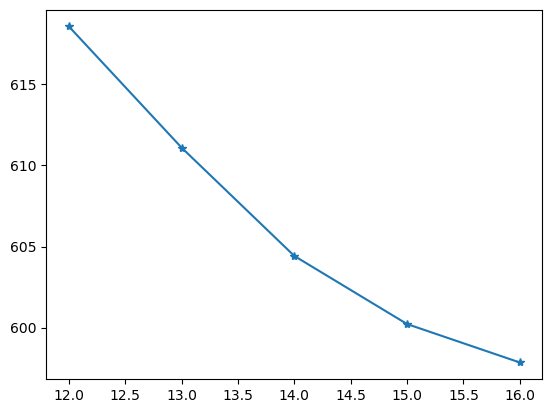

In [105]:
# list to save the clusters and cost
clusters = []
inertia_vals = []

explore_range = range(12, 17, 1)

for k in explore_range:
    # train clustering with the specified K
    model = KMeans(n_clusters=k, random_state=rs)
    model.fit(X_trans)
    
    # append model to cluster list
    clusters.append(model)
    inertia_vals.append(model.inertia_)

# plot the inertia vs K values
plt.plot(explore_range, inertia_vals, marker='*')
plt.show()


In [106]:
# programmatically generate and store silhouette scores for later
cluster_silhouettes = {}

for clust in range(len(clusters)):
    key = clusters[clust].n_clusters
    value = silhouette_score(X_trans, clusters[clust].predict(X_trans))
    cluster_silhouettes[key] = value
    
#     print(clusters[clust])
#     print(f"Silhouette score for k={key}", value)
#     print()

max_sil_score = max(cluster_silhouettes.values())
max_sil_clusters = get_key_by_value(cluster_silhouettes, max_sil_score)
print("Number of clusters: ", max_sil_clusters, "\nSilhouette Score: ", max_sil_score)

Number of clusters:  15 
Silhouette Score:  0.041368410210863314


#### Interpret results

*interpretation*

[Return to Task Navigation](#Task-3-Navigation)
***

## 3.6
#### How many clusters are generated?

In [108]:
# number of clusters
print(f'{max_sil_clusters} clusters are generated, with a silhouette score of {max_sil_score:.3}')

15 clusters are generated, with a silhouette score of 0.0414


#### Provide a way to meaningfully name each cluster and display the results.

In [71]:
# K-means clustering using LSA-transformed X
svd_kmeans = KMeans(n_clusters=max_sil_clusters, random_state=rs).fit(X_trans)

# transform cluster centers back to original feature space for visualisation
original_space_centroids = svd.inverse_transform(svd_kmeans.cluster_centers_)

# visualisation
visualise_text_cluster(svd_kmeans.n_clusters, original_space_centroids,
                       tfidf_filter.get_feature_names_out(), num_word = 50)

Top terms for cluster 0: best, friend, comedy, romantic, old, meet, set, turn, become, never, seem, face, take, big, series, begin, three, base, live, new, attempt, like, discover, though, get, well, save, even, age, see, end, go, come, time, high, follow, soon, real, whose, relationship, adventure, return, together, young, secret, move, way, force, another, school, 

Top terms for cluster 1: family, child, take, new, comedy, make, series, home, old, begin, turn, come, set, away, get, base, classic, face, lose, help, seem, character, human, son, john, land, man, big, well, friend, follow, however, try, show, wife, father, back, go, little, soon, long, learn, live, tell, leave, lead, age, know, though, force, 

Top terms for cluster 2: become, begin, take, tell, fall, make, mother, show, base, discover, return, adventure, like, old, american, tale, home, woman, lose, see, relationship, ever, turn, time, character, look, girl, lead, never, documentary, real, long, young, series, get, pla

[Return to Task Navigation](#Task-3-Navigation)
***

### Navigation
[EDA Tools](#edatools)
#### Tasks
1. [Clustering](#clustering)
1. [Association](#association)
1. [Text Analysis](#text)
1. [Web Log](#web)

***
# Task 4: Web Log Analysis<a name="web"></a>

### Task 4 Navigation
1. [Data Preprocessing](#4.1)
1. [Variables in Analysis](#4.2)
1. [Select & Justify Method](#4.3)
1. [Discussion of Results & Potential Applications](#4.4)

In [56]:
# import libraries
import pandas as pd
import numpy as np
from collections import defaultdict
import datetime
from sklearn.linear_model import LinearRegression

# load data
web_data = pd.read_csv('Weblog_v1.csv')

## 4.1
### Data Preprocessing

*Identify useful attributes.*

In [57]:
def preprocess_web_data(raw_web_data):
    # drop duplicates
    preprocess_df = raw_web_data.drop_duplicates()
    
    # rename columns
    preprocess_df = preprocess_df.rename(columns = {'IP address' : 'ip', 'Timestamp' : 'time',
                                                    'Request' : 'request', 'Staus' : 'status'})
    
    # remove all unsuccessful requests (code != 200)
    preprocess_df = preprocess_df[preprocess_df['status'] == 200]
    
    # remove leading square bracket from timestamp
    preprocess_df['time'] = preprocess_df['time'].str.replace('[', '')
    
    # convert to datetime 
    preprocess_df['time'] = pd.to_datetime(preprocess_df['time'], format= '%d/%b/%Y:%H:%M:%S')  
    
    # extract usernames
    usernames = preprocess_df['request'].str.extractall(r'.+nm=([\w]+)|\?user=([\w]+)|\?name=([\w]+)|show=([\w]+)')
    usernames = usernames.fillna('')
    usernames['username'] = usernames[0] + usernames[1] + usernames[2] + usernames[3]
    usernames = usernames['username'].droplevel(level=1)
    preprocess_df = preprocess_df.merge(usernames, left_index=True, right_index=True, how='left')
    
    # convert empty values back to NAs
    preprocess_df['username'] = preprocess_df['username'].replace('', np.nan).astype(object)
    
    # parse pages from requests
    request_splits = preprocess_df['request'].str.split(expand=True)
    preprocess_df['page'] = request_splits[1].str.extract(r'/(.*)\.php')
    
    # drop request column
    preprocess_df.drop(columns='request', inplace=True)

    # apply function above to get a new dataframe with added information
    web_sessions = preprocess_df.apply(get_log_user_info, axis=1)
    
    # Drop rows where 'page' is NaN
    web_sessions = web_sessions.dropna(subset=['page'])
    
    # Add 'sessionLength' column
    web_sessions['sessionLength'] = web_sessions.groupby('session')['time'].apply(lambda x: (x.max() - x.min()).seconds)
    # Drop rows where 'sessionLength' is NaN
    web_sessions.dropna(subset=['sessionLength'], inplace=True)
    # Filter and drop rows where 'sessionLength' is less than 1 (Bot traffic)
    web_sessions = web_sessions[web_sessions['sessionLength'] >= 1]
    
    web_sessions = pd.get_dummies(web_sessions, columns=['page'], prefix=[''], prefix_sep=[''])
    
    web_sessions = web_sessions.groupby('session').max().reset_index()
    
    # return only the required columns
    return web_sessions.iloc[:,6:]



def get_log_user_info(row):
    # access global variables shared between all rows
    global session_id, user_id, session_dict, user_id_dict, session_steps, last_access
    
    # date + IP key for finding session
    session_key = str(row['time'].date()) + '_' + row['ip']
    
    # date + IP + browser key for finding user
    user_key = str(row['time'].date()) + '_' + row['ip'] + '_' + str(row['username'])
    
    # session time diff
    time_diff_session = row['time'] - last_access[session_key]  
    
    # user time diff
    time_diff_user = row['time'] - last_access[user_key]  
    
    # if the time diff from previous session is > 30 mins, assign new session ID
    if time_diff_session.total_seconds() > 1800:
        session_id += 1
        session_dict[session_key] = session_id
    
    # if the time diff from previous session is > 60 mins, assign new user ID
    if time_diff_user.total_seconds() > 3600:
        user_id += 1
        user_id_dict[user_key] = user_id
        
    # update last access for session and user
    last_access[session_key] = row['time']
    last_access[user_key] = row['time']
    
    # assign extracted info from the row
    row['session'] = session_dict[session_key]
    row['step'] = session_steps[row['session']]
    row['userID'] = user_id_dict[user_key]
    session_steps[row['session']] += 1
    return row

In [58]:
# initialise global vars for preprocessing
session_id = 0
user_id = 0

# create a dictionaries to hold last access information
last_access = defaultdict(lambda:datetime.datetime.utcfromtimestamp(0))
# dictionary to find previous session, user ID
# and steps assigned to a specific date/ip/browser key
session_dict = defaultdict(lambda:1)
user_id_dict = defaultdict(lambda:1)
session_steps = defaultdict(lambda:1)

In [59]:
# preprocess web log data
web_df = preprocess_web_data(web_data)

In [60]:
# EDA
# very few non '.php' URLs
# not missing anything important by only capturing '.php' pages


# urls = web_data['Request'].str.split(expand=True)[1]
# urls.str.split(pat='?', expand=True)[0].unique()

[Return to Task Navigation](#Task-4-Navigation)
***

## 4.2
### Variables included in analysis

What were the variables roles and measurement levels set to? Justify choices.

[Return to Task Navigation](#Task-4-Navigation)
***

## 4.3
### Select and apply a data mining method to the processed dataset.

Justify choice.

In [61]:
# generate training data and dependent variable sets
X_lm = web_df.iloc[:, 1:]
y_lm = web_df.iloc[:, 0]

# fit the linear model
web_lm = LinearRegression().fit(X_lm, y_lm)

In [62]:
# create df of features and their coefficient values
coefs = pd.DataFrame(list(zip(web_lm.feature_names_in_, web_lm.coef_)), 
                    columns = ['page', 'coef'])

# filter out features with an predicted effect of less than +/- 1 second
# sort by descending absolute value of coefficient value
coefs = coefs.loc[coefs['coef'].abs() > 1].sort_values(by='coef', key=abs, ascending=False).reset_index(drop=True)

# calculate whole minute approximations for easier interpretation
coefs['minutes'] = (coefs['coef']/60).round(0).astype(int)

# calculate hours approximations for easier interpretation
coefs['hours'] = (coefs['coef']/3600).round(2)

[Return to Task Navigation](#Task-4-Navigation)
***

## 4.4
### Discuss results and potential application of the findings.

Include only a high-level, managerial-style, discussion of the findings.

It should **not** just be an interpretation of results as shown in results.

In [63]:
# R^2: Coefficient of Determination
# proportion of variation in Y that is explained by x, i.e. therefor by the model
print(f"The model explains {web_lm.score(X_lm, y_lm):.2%} of the variability in the data")

The model explains 73.54% of the variability in the data


In [64]:
coefs

,page,coef,minutes,hours
0,index,-40803.933174,-680,-11.33
1,showcode,36179.856006,603,10.05
2,contestsubmission,-22689.575975,-378,-6.30
3,pcompile,21788.661893,363,6.05
4,details,19355.926810,323,5.38
5,allsubmission,-18860.631663,-314,-5.24
6,profile,12042.676213,201,3.35
7,description,-11090.263325,-185,-3.08
8,submit,-7253.921241,-121,-2.01
9,home,3494.901352,58,0.97


[Return to Task Navigation](#Task-4-Navigation)
***